# Figure 1

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.patches import Rectangle, FancyArrowPatch, Patch
from scipy.spatial import Voronoi
from scipy.ndimage import gaussian_filter
from scipy.interpolate import NearestNDInterpolator, griddata
import scipy.sparse as sp
import scipy.sparse.linalg as spla

EPS = 1e-12

# --- colormaps ---
try:
    import cmcrameri.cm as cmc
    CMAP_K = cmc.batlow
    CMAP_SS = cmc.oslo
    CMAP_FLOW = cmc.lajolla
except Exception:
    CMAP_K = plt.get_cmap("viridis")
    CMAP_SS = plt.get_cmap("cividis")
    CMAP_FLOW = plt.get_cmap("magma")

# --- geometry helpers ---
def generate_pcc_mesh_ghost(Lx, Ly, n_cells, seed=42):
    rng = np.random.default_rng(seed)
    pts = rng.random((n_cells, 2))
    pts[:, 0] *= Lx
    pts[:, 1] *= Ly

    ghosts = [
        np.column_stack((-pts[:, 0], pts[:, 1])),            # Left
        np.column_stack((2*Lx - pts[:, 0], pts[:, 1])),      # Right
        np.column_stack((pts[:, 0], -pts[:, 1])),            # Bottom
        np.column_stack((pts[:, 0], 2*Ly - pts[:, 1])),      # Top
    ]
    all_pts = np.vstack([pts] + ghosts)
    vor = Voronoi(all_pts)
    return vor, pts, all_pts

def voronoi_polygons(vor, n_internal):
    polys = []
    idx = []
    for i in range(n_internal):
        rid = vor.point_region[i]
        reg = vor.regions[rid]
        if -1 in reg or len(reg) == 0:
            continue
        verts = vor.vertices[reg]
        # sort vertices by angle for a clean polygon
        c = verts.mean(axis=0)
        ang = np.arctan2(verts[:,1]-c[1], verts[:,0]-c[0])
        verts = verts[np.argsort(ang)]
        polys.append(verts)
        idx.append(i)
    return polys, np.array(idx, dtype=int)

def voronoi_segments(vor, n_internal):
    segs = []
    for (p1,p2),(v1,v2) in zip(vor.ridge_points, vor.ridge_vertices):
        if v1 < 0 or v2 < 0:
            continue
        if (p1 < n_internal) or (p2 < n_internal):
            segs.append([vor.vertices[v1], vor.vertices[v2]])
    return segs

def build_faces(vor, all_pts, n_internal):
    internal, boundary = [], []
    for (p1,p2),(v1,v2) in zip(vor.ridge_points, vor.ridge_vertices):
        if v1 < 0 or v2 < 0:
            continue
        dist = np.linalg.norm(all_pts[p1] - all_pts[p2])
        if dist < 1e-12:
            continue
        face_len = np.linalg.norm(vor.vertices[v1] - vor.vertices[v2])

        in1, in2 = p1 < n_internal, p2 < n_internal
        if in1 and in2:
            internal.append((p1, p2, face_len, dist))
        elif in1 ^ in2:
            p_in = p1 if in1 else p2
            p_out = p2 if in1 else p1
            off = p_out - n_internal
            if off < n_internal:
                bc = "Left"
            elif off < 2*n_internal:
                bc = "Right"
            elif off < 3*n_internal:
                bc = "Bottom"
            else:
                bc = "Top"
            boundary.append((p_in, bc, face_len, dist/2.0))
    return internal, boundary

def solve_steady_head(n, internal, boundary, K_vals):
    # Dirichlet: Left=1, Right=0. Top/Bottom no-flow
    row, col, data = [], [], []
    rhs = np.zeros(n, dtype=float)

    for (i,j,L,D) in internal:
        T = 2*K_vals[i]*K_vals[j]/(K_vals[i]+K_vals[j]+EPS) * (L/(D+EPS))
        row += [i,i,j,j]
        col += [i,j,i,j]
        data += [T, -T, -T, T]

    for (i,bc,L,Db) in boundary:
        if bc in ["Top","Bottom"]:
            continue
        Tb = K_vals[i] * (L/(Db+EPS))
        row.append(i); col.append(i); data.append(Tb)
        if bc == "Left":
            rhs[i] += Tb*1.0

    A = sp.csr_matrix((data, (row, col)), shape=(n, n))
    h = spla.spsolve(A, rhs)
    return h

def compute_velocity(pts, internal, h, K_vals):
    n = len(pts)
    v = np.zeros((n,2), dtype=float)
    for (i,j,L,D) in internal:
        T = 2*K_vals[i]*K_vals[j]/(K_vals[i]+K_vals[j]+EPS) * (L/(D+EPS))
        q = T*(h[i]-h[j])
        u = (pts[j]-pts[i])/(np.linalg.norm(pts[j]-pts[i])+EPS)
        v[i] += q*u
        v[j] -= q*u
    speed = np.linalg.norm(v, axis=1)
    return v, speed

# --- field generators ---
def gen_lnK(nx, ny, dx, rng, model_type, mu_ln=0.0, sigma_ln=2.0, corr_len=20.0):
    z = rng.normal(0,1,(ny,nx))
    f = gaussian_filter(z, sigma=max(1e-6, corr_len/dx), mode="reflect")
    f = (f - f.mean())/(f.std()+EPS)

    if model_type == 0:
        g = f
    elif model_type == 1:
        g = -np.abs(f)
        g = (g - g.mean())/(g.std()+EPS)
    else:
        g = np.where(f > 0.5, 1.0, -1.0)

    return g*sigma_ln + mu_ln

def gen_lnSs_correlated(lnK, nx, ny, dx, rng, mu_lnSs=-6.0, sigma_lnSs=1.0, corr_len_Ss=20.0, rho=0.5):
    Zk = (lnK - lnK.mean())/(lnK.std()+EPS)
    z2 = rng.normal(0,1,(ny,nx))
    z2 = gaussian_filter(z2, sigma=max(1e-6, corr_len_Ss/dx), mode="reflect")
    Z2 = (z2 - z2.mean())/(z2.std()+EPS)
    rho = float(np.clip(rho, -1, 1))
    Zs = rho*Zk + np.sqrt(max(0.0, 1-rho**2))*Z2
    return Zs*sigma_lnSs + mu_lnSs

# =========================
# Scenario definition
# =========================
Lx, Ly = 100.0, 100.0
N_CELLS = 4000
MESH_SEED = 101

# severity sweep
corrK_levels = np.linspace(30.0, 10.0, 6)
corrS_levels = np.linspace(30.0, 10.0, 6)

SIGMA_LEVELS = [
    {"name":"L1", "sigma_lnK":0.6, "sigma_lnSs":0.25, "corr_len_K":12.0, "corr_len_Ss":12.0},
    {"name":"L2", "sigma_lnK":1.0, "sigma_lnSs":0.40, "corr_len_K":10.0, "corr_len_Ss":10.0},
    {"name":"L3", "sigma_lnK":1.6, "sigma_lnSs":0.65, "corr_len_K":8.0, "corr_len_Ss":8.0},
    {"name":"L4", "sigma_lnK":2.3, "sigma_lnSs":0.95, "corr_len_K":6.0, "corr_len_Ss":6.0},
    {"name":"L5", "sigma_lnK":3.1, "sigma_lnSs":1.20, "corr_len_K":4.0, "corr_len_Ss":4.0},
    {"name":"L6", "sigma_lnK":4.0, "sigma_lnSs":1.50, "corr_len_K":2.0, "corr_len_Ss":2.0},
]


CORR_LEN_K = 20.0
CORR_LEN_SS = 20.0
RHO = 0.5

# choose one seed per column for the sigma-sweep figure
FIELD_SEED_BASE = 42

# if you also want a seed-sweep figure later
SEED_SWEEP = [11, 22, 33]   # optional

# grid for generating fields
NXG, NYG = 301, 301
dx = Lx/(NXG-1)
y_g, x_g = np.mgrid[0:Ly:complex(0, NYG), 0:Lx:complex(0, NXG)]
grid_pts = np.column_stack([x_g.ravel(), y_g.ravel()])

# flow grid for streamplot
FLOW_N = 140
xi = np.linspace(0, Lx, FLOW_N)
yi = np.linspace(0, Ly, FLOW_N)
Xi, Yi = np.meshgrid(xi, yi)

# =========================
# Build mesh once
# =========================
vor, pts, all_pts = generate_pcc_mesh_ghost(Lx, Ly, N_CELLS, MESH_SEED)
polys, poly_idx = voronoi_polygons(vor, N_CELLS)
segs = voronoi_segments(vor, N_CELLS)
internal_faces, boundary_faces = build_faces(vor, all_pts, N_CELLS)

# =========================
# Precompute results for sigma sweep
# results[(severity_idx, model_type)] = dict(...)
# =========================
results_sigma = {}
results_flow = {}  # only for Extreme row

for s_i, lev in enumerate(SIGMA_LEVELS):
    for m_type in [0,1,2]:
        rng = np.random.default_rng(FIELD_SEED_BASE + 100*m_type + 10*s_i)

        lnK = gen_lnK(NXG, NYG, dx, rng, m_type,
                     mu_ln=0.0, sigma_ln=lev["sigma_lnK"], corr_len=lev["corr_len_K"])
        lnSs = gen_lnSs_correlated(lnK, NXG, NYG, dx, rng,
                                   mu_lnSs=-6.0, sigma_lnSs=lev["sigma_lnSs"],
                                   corr_len_Ss=lev["corr_len_Ss"], rho=RHO)

        K_grid = np.exp(lnK)
        Ss_grid = np.exp(lnSs)

        interpK = NearestNDInterpolator(grid_pts, K_grid.ravel())
        interpSs = NearestNDInterpolator(grid_pts, Ss_grid.ravel())

        K_pcc = interpK(pts)
        Ss_pcc = interpSs(pts)

        lnK_pcc = np.log(K_pcc + EPS)
        lnSs_pcc = np.log(Ss_pcc + EPS)

        # normalize to show structure comparably across sigma
        lnK_norm = (lnK_pcc - 0.0) / lev["sigma_lnK"]
        lnSs_norm = (lnSs_pcc - (-6.0)) / lev["sigma_lnSs"]

        results_sigma[(s_i, m_type)] = {
            "severity": lev["name"],
            "model_type": m_type,
            "sigma_lnK": lev["sigma_lnK"],
            "sigma_lnSs": lev["sigma_lnSs"],
            "lnK_norm_poly": lnK_norm[poly_idx],
            "lnSs_norm_poly": lnSs_norm[poly_idx],
        }

        # compute flow only for Extreme row by default
        if lev["name"] == "Extreme":
            h = solve_steady_head(len(pts), internal_faces, boundary_faces, K_pcc)
            v, speed = compute_velocity(pts, internal_faces, h, K_pcc)
            log_speed = np.log10(speed + EPS)

            vx_g = griddata(pts, v[:,0], (Xi, Yi), method="linear", fill_value=0.0)
            vy_g = griddata(pts, v[:,1], (Xi, Yi), method="linear", fill_value=0.0)

            results_flow[m_type] = {
                "log_speed_poly": log_speed[poly_idx],
                "h": h,
                "vx_g": vx_g,
                "vy_g": vy_g,
            }

# global color limits
K_CLIM = (-2.2, 2.2)
SS_CLIM = (-2.2, 2.2)

if results_flow:
    all_logv = np.hstack([results_flow[m]["log_speed_poly"] for m in results_flow])
    V_CLIM = np.percentile(all_logv, [2, 98])
else:
    V_CLIM = (-6, 0)


# Cell 1. Compute / prepare (no plotting)

import numpy as np

# Required objects should already exist from your compute pipeline:
# SIGMA_LEVELS, results_sigma, polys, segs, Lx, Ly, K_CLIM, SS_CLIM

required = ["SIGMA_LEVELS", "results_sigma", "polys", "segs", "Lx", "Ly", "K_CLIM", "SS_CLIM"]
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(f"Missing required variables: {missing}")

MT_LEVELS = [0, 1, 2]
MT_NAME = {0: "Gaussian", 1: "Connectivity", 2: "Boolean"}

# Extract arrays once. So you can re-run the plot cell quickly.
valsK = {}
valsS = {}
for s_i, _ in enumerate(SIGMA_LEVELS):
    for m_type in MT_LEVELS:
        valsK[(s_i, m_type)] = results_sigma[(s_i, m_type)]["lnK_norm_poly"]
        valsS[(s_i, m_type)] = results_sigma[(s_i, m_type)]["lnSs_norm_poly"]

payload = {
    "SIGMA_LEVELS": SIGMA_LEVELS,
    "MT_LEVELS": MT_LEVELS,
    "MT_NAME": MT_NAME,
    "valsK": valsK,
    "valsS": valsS,
    "polys": polys,
    "segs": segs,
    "Lx": Lx,
    "Ly": Ly,
    "K_CLIM": K_CLIM,
    "SS_CLIM": SS_CLIM,
}
print("Prepared payload for plotting.")

Prepared payload for plotting.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import PolyCollection, LineCollection
import os

# ==============================================================================
# 1. Environment checks and data preparation
# ==============================================================================

# (A) Check mesh payload
if "payload" not in globals():
    raise RuntimeError("? Error: run the mesh generation cell at the top first to ensure the 'payload' variable exists.")

# Prepare the most extreme cases for the three models (L6 = index 5)
hero_s_i = 5 
# Extract the conductivity fields for the three models
# Model 0: Gaussian, Model 1: Connectivity, Model 2: Boolean
valsK_list = []
titles_list = ["Gaussian-like", "Connectivity-driven", "Boolean-like"]
for m_type in [0, 1, 2]:
    valsK_list.append(payload["valsK"][(hero_s_i, m_type)])

polys = payload["polys"]
segs = payload["segs"]
Lx, Ly = payload["Lx"], payload["Ly"]
K_CLIM = payload["K_CLIM"]

# Set the colormap
try:
    cmap_k_use = CMAP_K
except NameError:
    cmap_k_use = plt.get_cmap("viridis")

# (B) Prepare physics simulation data
DATA_DIR = "." # Ensure the .npy files are in this directory
EXP_NAME = "midband_multisine"

q_path = os.path.join(DATA_DIR, f"q_{EXP_NAME}.npy")
g_path = os.path.join(DATA_DIR, f"grad_{EXP_NAME}.npy")
bc_path = os.path.join(DATA_DIR, "bc_info.npz")

# Default data containers
t_physics, grad_norm, q_norm = None, None, None
max_area = 0.0

if os.path.exists(q_path):
    print(f"Loading physics data from {DATA_DIR}...")
    q_data = np.lib.format.open_memmap(q_path, mode="r")
    g_data = np.lib.format.open_memmap(g_path, mode="r")
    bc_info = np.load(bc_path)

    # Rebuild the time axis
    all_names = bc_info["names"]
    exp_idx = np.where(all_names == EXP_NAME)[0][0]
    T_val = bc_info["T"][exp_idx]
    nt_val = bc_info["nt"][exp_idx]
    t_full = np.linspace(0.0, T_val, int(nt_val))
    t_physics = t_full[1:] # Skip t=0

    # Find the largest loop
    scan_limit = min(len(q_data), 500)
    hero_idx = 0
    for i in range(scan_limit):
        q_i = q_data[i]
        g_i = g_data[i]
        area = 0.5 * np.abs(np.dot(g_i, np.roll(q_i, 1)) - np.dot(q_i, np.roll(g_i, 1)))
        if area > max_area:
            max_area = area
            hero_idx = i
            
    print(f"Using Sample #{hero_idx} for Physics Curves (Area={max_area:.2f})")
    grad_raw = g_data[hero_idx]
    q_raw = q_data[hero_idx]
    
    # Normalize
    grad_norm = (grad_raw - np.mean(grad_raw)) / np.std(grad_raw)
    q_norm = (q_raw - np.mean(q_raw)) / np.std(q_raw)
else:
    print("?? Warning: physics data not found; using synthetic data for illustration.")
    t_physics = np.linspace(0, 200, 200)
    grad_norm = np.sin(t_physics/10)
    q_norm = 0.8 * np.sin(t_physics/10 - 0.8)

Loading physics data from ....
Using Sample #290 for Physics Curves (Area=0.60)


Loading physics data from ....
Using Sample #290 for physics curves (area=0.60)
Saved PDF: Figure1.pdf
Saved PNG: Figure1.png


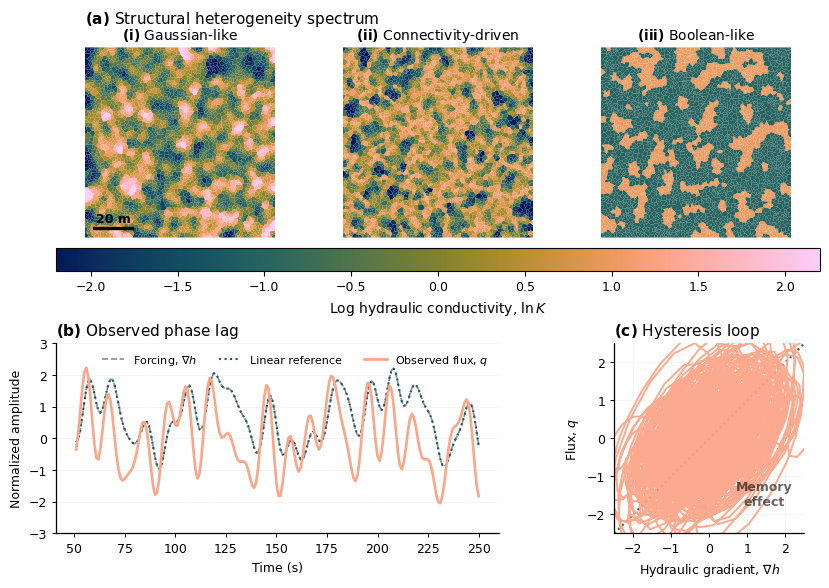

In [24]:
# ==============================================================================
# Layout update you requested:
# - Put (b) and (c) BELOW (a), arranged 1x2 with width ratio 2:1
# - Keep the triptych (a-i/ii/iii) on the top row with a shared colorbar below it
# - Academic notation for labels (∇h, q, ln K, τ_q)
# - Uses cmc.batlow consistently
# - Saves to PDF (requested) + optional PNG
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import PolyCollection
import os

# ==============================================================================
# 1) Data preparation
# ==============================================================================
if "payload" not in globals():
    raise RuntimeError("payload not found. Please run the grid-generation cell first.")

hero_s_i = 5
titles_list = ["Gaussian-like", "Connectivity-driven", "Boolean-like"]

valsK_list = []
for m_type in [0, 1, 2]:
    valsK_list.append(payload["valsK"][(hero_s_i, m_type)])

polys = payload["polys"]
Lx, Ly = float(payload["Lx"]), float(payload["Ly"])
K_CLIM = payload["K_CLIM"]

# Colormap
try:
    from cmcrameri import cm as cmc
    cmap_k_use = cmc.batlow
except Exception:
    cmap_k_use = plt.get_cmap("cividis")

# ---- Physics data from npy (or synthetic fallback) ----
DATA_DIR = "."
EXP_NAME = "midband_multisine"

q_path = os.path.join(DATA_DIR, f"q_{EXP_NAME}.npy")
g_path = os.path.join(DATA_DIR, f"grad_{EXP_NAME}.npy")
bc_path = os.path.join(DATA_DIR, "bc_info.npz")

if os.path.exists(q_path) and os.path.exists(g_path) and os.path.exists(bc_path):
    print(f"Loading physics data from {DATA_DIR}...")
    q_data = np.lib.format.open_memmap(q_path, mode="r")
    g_data = np.lib.format.open_memmap(g_path, mode="r")
    bc_info = np.load(bc_path, allow_pickle=True)

    all_names = bc_info["names"]
    exp_idx = np.where(all_names == EXP_NAME)[0][0]
    T_val = float(bc_info["T"][exp_idx])
    nt_val = int(bc_info["nt"][exp_idx])
    t_full = np.linspace(0.0, T_val, nt_val)
    t_physics = t_full[1:]  # skip t=0

    # choose hero by maximum hysteresis area
    scan_limit = min(len(q_data), 500)
    hero_idx = 0
    max_area = -np.inf
    for i in range(scan_limit):
        q_i = np.asarray(q_data[i], dtype=float)
        g_i = np.asarray(g_data[i], dtype=float)
        area = 0.5 * np.abs(np.dot(g_i, np.roll(q_i, 1)) - np.dot(q_i, np.roll(g_i, 1)))
        if area > max_area:
            max_area = area
            hero_idx = i

    print(f"Using Sample #{hero_idx} for physics curves (area={max_area:.2f})")
    grad_raw = np.asarray(g_data[hero_idx], dtype=float)
    q_raw = np.asarray(q_data[hero_idx], dtype=float)

    grad_norm = (grad_raw - np.mean(grad_raw)) / (np.std(grad_raw) + 1e-12)
    q_norm = (q_raw - np.mean(q_raw)) / (np.std(q_raw) + 1e-12)
else:
    print("⚠️ Physics files not found. Using synthetic demo signals.")
    t_physics = np.linspace(0, 200, 200)
    grad_norm = np.sin(t_physics / 10.0)
    q_norm = 0.8 * np.sin(t_physics / 10.0 - 0.8)

# ==============================================================================
# 2) Plotting
# ==============================================================================
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 9,
    "axes.linewidth": 0.9,
    "mathtext.fontset": "dejavusans",
})

def style_axes(ax, grid_axis=None):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis is not None:
        ax.grid(True, axis=grid_axis, linestyle="--", linewidth=0.5, alpha=0.22)
    ax.tick_params(length=3, width=0.7)

def _batlow_discrete(n):
    try:
        from cmcrameri import cm as cmc
        cmap = cmc.batlow
    except Exception:
        cmap = plt.get_cmap("cividis")
    return [cmap(v) for v in np.linspace(0.22, 0.80, n)]

C_REF, C_OBS = _batlow_discrete(2)  # reference + observed
C_FORC = (0, 0, 0, 0.45)            # forcing in neutral gray

# ==============================================================================
# Figure layout:
# Row 1: (a) triptych (1x3) + its colorbar
# Row 2: (b) and (c) side-by-side, width ratio 2:1
# ==============================================================================
fig = plt.figure(figsize=(8, 6))
gs_outer = gridspec.GridSpec(2, 1, height_ratios=[1.0, 0.85], hspace=0.35)
fig.subplots_adjust(left=0.04, right=0.995, top=0.93, bottom=0.12)

# -----------------------------
# Top block: (a) triptych + cbar
# -----------------------------
gs_top = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_outer[0], height_ratios=[1.0, 0.12], hspace=0.10)
gs_maps = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_top[0], wspace=0.04)

pc_last = None
for idx, (vals, title) in enumerate(zip(valsK_list, titles_list)):
    ax = fig.add_subplot(gs_maps[idx])

    pc = PolyCollection(polys, array=np.asarray(vals, dtype=float), cmap=cmap_k_use,
                        edgecolors="none", rasterized=True)
    pc.set_clim(*K_CLIM)
    ax.add_collection(pc)
    pc_last = pc

    roman = ["i", "ii", "iii"][idx]
    ax.set_title(rf"$\mathbf{{({roman})}}$ {title}", fontsize=10)

    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    ax.set_aspect("equal")
    ax.axis("off")

    if idx == 0:
        ax.plot([5, 25], [5, 5], color="k", lw=2.4)
        ax.text(15, 8, "20 m", ha="center", fontsize=9, fontweight="bold")
        ax.text(0, Ly * 1.1, r"$\mathbf{(a)}$ Structural heterogeneity spectrum",
                fontsize=11, ha="left", va="bottom")

cax = fig.add_subplot(gs_top[1])
cb = fig.colorbar(pc_last, cax=cax, orientation="horizontal")
cb.set_label(r"Log hydraulic conductivity, $\ln K$", fontsize=10)
cb.outline.set_linewidth(0.8)

# -----------------------------
# Bottom block: (b) and (c) 1x2 with width ratio 2:1
# -----------------------------
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_outer[1], width_ratios=[2.0, 1.0], wspace=0.30)

# (b) Time-domain phase lag (wide)
ax_time = fig.add_subplot(gs_bottom[0])

n_zoom = 200
start_idx = 50
t_z = t_physics[start_idx:start_idx + n_zoom]
g_z = grad_norm[start_idx:start_idx + n_zoom]
q_z = q_norm[start_idx:start_idx + n_zoom]

ax_time.plot(t_z, g_z, ls="--", lw=1.2, color=C_FORC, label=r"Forcing, $\nabla h$")
ax_time.plot(t_z, g_z, ls=":",  lw=1.5, color=C_REF,  label="Linear reference")
ax_time.plot(t_z, q_z, ls="-",  lw=1.9, color=C_OBS,  label=r"Observed flux, $q$")

ax_time.set_ylim(-3,3)
ax_time.set_xlabel("Time (s)")
ax_time.set_ylabel("Normalized amplitude")
ax_time.set_title(r"$\mathbf{(b)}$ Observed phase lag", loc="left", fontsize=11)
style_axes(ax_time, grid_axis="y")

# compact legend inside, no overflow
ax_time.legend(frameon=False, fontsize=8, ncol=3, loc="upper right")

# (c) Hysteresis loop (narrow, square)
ax_loop = fig.add_subplot(gs_bottom[1])

limit = 2.5
ax_loop.plot([-limit, limit], [-limit, limit], ls=":", lw=1.5, color=C_REF, label="Linear reference")
ax_loop.plot(grad_norm, q_norm, ls="-", lw=1.4, color=C_OBS, alpha=0.95, label="Observed loop")

mid = len(g_z) // 2
if mid + 1 < len(g_z):
    ax_loop.annotate("", xy=(g_z[mid + 1], q_z[mid + 1]), xytext=(g_z[mid], q_z[mid]),
                     arrowprops=dict(arrowstyle="->", color=C_OBS, lw=1.4))

ax_loop.set_aspect("equal", adjustable="box")
ax_loop.set_xlim(-limit, limit)
ax_loop.set_ylim(-limit, limit)
ax_loop.set_xlabel(r"Hydraulic gradient, $\nabla h$")
ax_loop.set_ylabel(r"Flux, $q$")
ax_loop.set_title(r"$\mathbf{(c)}$ Hysteresis loop", loc="left", fontsize=11)
ax_loop.grid(True, ls="--", alpha=0.22, linewidth=0.5)
ax_loop.text(1.45, -1.75, "Memory\neffect", ha="center", color=(0, 0, 0, 0.60),
             fontsize=9, fontweight="bold")
style_axes(ax_loop)

# ==============================================================================
# 3) Save
# ==============================================================================
out_pdf = "Figure1.pdf"
fig.savefig(out_pdf, bbox_inches="tight")
print("Saved PDF:", out_pdf)

out_png = "Figure1.png"
fig.savefig(out_png, dpi=600, bbox_inches="tight")
print("Saved PNG:", out_png)

plt.show()


# Figure 3

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import sys
import warnings

warnings.filterwarnings('ignore')

# ==============================================================================
# 1. Configuration & Data Loading
# ==============================================================================
CSV_PATH = "Mission_Hydro_Hybrid_DPL_Rebuilt.csv"
CONFIG = {
    "N_CUTOFF": 9200,
    "TAU_Q_PARAMS": {"max_depth": 5, "learning_rate": 0.018, "n_estimators": 500, "n_jobs": -1, "random_state": 42},
    "TAU_H_PARAMS": {"max_depth": 5, "learning_rate": 0.020, "n_estimators": 500, "n_jobs": -1, "random_state": 42},
}

try:
    df = pd.read_csv(CSV_PATH)
    print(f"✅ Loaded {CSV_PATH} ({len(df)} samples)")
except FileNotFoundError:
    print(f"❌ Error: {CSV_PATH} not found.")
    sys.exit()

df = df.dropna(subset=["Target_LogTau_q", "Target_LogTau_h"])
# Base physics terms (linear theory basis)
df["Phys_Theory"] = np.log10(df["Geostat_Mu_Ss"] / (df["Geostat_Mu_K"] + 1e-12))

keywords = ['Phys_Perc_', 'Geostat_', 'Phys_Info_', 'Phys_Morph_']
features = [c for c in df.columns if any(k in c for k in keywords)]
features = [f for f in features if 'Target' not in f and 'Theory' not in f]

# ==============================================================================
# 2. PGRL Engine: Inference & Residual Calculation
# ==============================================================================
def run_pgrl_inference(df, features, target_col, params):
    print(f"⚙️ Running PGRL Inference for {target_col}...")
    
    # 1. Linear Physics Baseline
    X_theory = df["Phys_Theory"].values.reshape(-1, 1)
    y_true = df[target_col].values
    
    reg_base = LinearRegression().fit(X_theory, y_true)
    y_base_all = reg_base.predict(X_theory)
    
    # Compute residuals (used for color mapping)
    # Larger residuals = stronger non-Darcy effects = brighter color
    residuals_all = y_true - y_base_all
    resid_magnitude = np.abs(residuals_all) 
    
    # 2. Golden Filtering
    df_temp = df.copy()
    df_temp['Resid_Sq'] = residuals_all**2
    df_golden = df_temp.sort_values('Resid_Sq').head(CONFIG["N_CUTOFF"]).copy()
    
    # 3. XGBoost Residual Learning
    model = xgb.XGBRegressor(**params)
    model.fit(df_golden[features], residuals_all[df_golden.index])
    
    y_resid_pred = model.predict(df_golden[features])
    y_final_pred = y_base_all[df_golden.index] + y_resid_pred
    y_golden_true = df_golden[target_col].values
    
    # Return residual magnitude as the color value
    # Normalize residuals (0-1) for plotting
    c_vals = resid_magnitude[df_golden.index]
    c_vals = (c_vals - c_vals.min()) / (c_vals.max() - c_vals.min())
    
    return y_golden_true, y_final_pred, c_vals

# Run inference
y_true_q, y_pred_q, color_q = run_pgrl_inference(df, features, "Target_LogTau_q", CONFIG["TAU_Q_PARAMS"])
y_true_h, y_pred_h, color_h = run_pgrl_inference(df, features, "Target_LogTau_h", CONFIG["TAU_H_PARAMS"])



✅ Loaded Mission_Hydro_Hybrid_DPL_Rebuilt.csv (10000 samples)
⚙️ Running PGRL Inference for Target_LogTau_q...
⚙️ Running PGRL Inference for Target_LogTau_h...


Saved PDF: Figure3.pdf
Saved PNG: Figure3.png


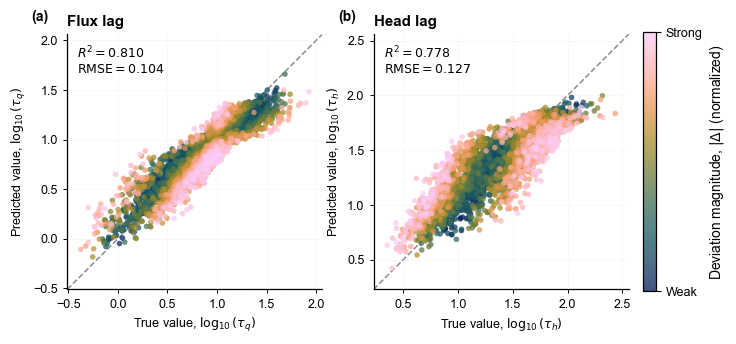

In [115]:
# ==============================================================================
# Figure 3 (Refined). Two parity plots with shared colorbar (Nature-style)
# - Uses cmc.batlow (consistent, perceptually uniform)
# - Academic notation: log10(τ_q), log10(τ_h), and a neutral deviation label
# - One shared colorbar, clean margins (no layout collapse)
# - Saves to PDF (requested) + optional PNG
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import r2_score, mean_squared_error

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "font.size": 9,
    "axes.linewidth": 0.9,
    "mathtext.fontset": "dejavusans",
})

# colormap: batlow
try:
    from cmcrameri import cm as cmc
    cmap = cmc.batlow
except Exception:
    cmap = plt.get_cmap("cividis")

def style_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, axis="both", linestyle="--", linewidth=0.5, alpha=0.18)
    ax.tick_params(length=3, width=0.7)

def plot_parity_panel(ax, y_true, y_pred, c_vals, title, panel_letter, tau_symbol):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    c_vals = np.asarray(c_vals, dtype=float)

    m = np.isfinite(y_true) & np.isfinite(y_pred) & np.isfinite(c_vals)
    y_true = y_true[m]; y_pred = y_pred[m]; c_vals = c_vals[m]

    r2 = float(r2_score(y_true, y_pred)) if y_true.size else np.nan
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred))) if y_true.size else np.nan

    # symmetric limits around data
    vmin = float(np.nanmin(np.r_[y_true, y_pred]))
    vmax = float(np.nanmax(np.r_[y_true, y_pred]))
    pad = 0.06 * (vmax - vmin + 1e-12)
    vmin -= pad
    vmax += pad

    # 1:1 line
    ax.plot([vmin, vmax], [vmin, vmax], color=(0, 0, 0, 0.45), ls="--", lw=1.1, zorder=1)

    # scatter
    sc = ax.scatter(
        y_true, y_pred,
        c=c_vals, cmap=cmap,
        s=16, alpha=0.75,
        edgecolors="none",
        zorder=2
    )

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(vmin, vmax); ax.set_ylim(vmin, vmax)

    ax.set_xlabel(rf"True value, $\log_{{10}}({tau_symbol})$")
    ax.set_ylabel(rf"Predicted value, $\log_{{10}}({tau_symbol})$")
    ax.set_title(title, loc="left", fontweight="bold")

    # compact stats box
    txt = rf"$R^2={r2:.3f}$" + "\n" + rf"$\mathrm{{RMSE}}={rmse:.3f}$"
    ax.text(
        0.04, 0.96, txt,
        transform=ax.transAxes, ha="left", va="top",
        fontsize=9
    )

    # panel letter
    ax.text(-0.14, 1.04, f"({panel_letter})", transform=ax.transAxes,
            fontsize=10, fontweight="bold", va="bottom")

    style_axes(ax)
    return sc

# ---- figure layout (manual, stable) ----
fig = plt.figure(figsize=(7.2, 3.6))
gs = GridSpec(1, 2, figure=fig, wspace=0.20)
fig.subplots_adjust(left=0.10, right=0.88, top=0.90, bottom=0.18)

ax1 = fig.add_subplot(gs[0, 0])
sc1 = plot_parity_panel(
    ax1, y_true_q, y_pred_q, color_q,
    title="Flux lag", panel_letter="a", tau_symbol=r"\tau_q"
)

ax2 = fig.add_subplot(gs[0, 1])
sc2 = plot_parity_panel(
    ax2, y_true_h, y_pred_h, color_h,
    title="Head lag", panel_letter="b", tau_symbol=r"\tau_h"
)

# ---- shared colorbar (right) ----
cax = fig.add_axes([0.90, 0.18, 0.018, 0.72])
cbar = fig.colorbar(sc1, cax=cax)

# Academic / neutral label (avoid over-claiming)
cbar.set_label(r"Deviation magnitude, $|\Delta|$ (normalized)", fontsize=10)

# If your c_vals are already 0..1, keep ticks as Weak/Strong.
# Otherwise, comment the next two lines and let matplotlib auto-scale.
cbar.set_ticks([np.nanmin(color_q), np.nanmax(color_q)])
cbar.set_ticklabels(["Weak", "Strong"])

# ---- save ----
out_pdf = "Figure3.pdf"
fig.savefig(out_pdf, bbox_inches="tight")
print("Saved PDF:", out_pdf)

out_png = "Figure3.png"
fig.savefig(out_png, dpi=600, bbox_inches="tight")
print("Saved PNG:", out_png)

plt.show()


# Figure 4

In [110]:
# ==============================================================================
# Figure 4 Step 1: PGRL Analysis (Full Physics Mode)
# Goal: show complete feature-importance ranking (global + local)
# ==============================================================================
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import sys
import os
import warnings

warnings.filterwarnings('ignore')

# ------------------------------------------------------------------
# 1. Configuration
# ------------------------------------------------------------------
CSV_PATH = "Mission_Hydro_Hybrid_DPL_Rebuilt.csv"
OUTPUT_DIR = "Fig4_Data_Cache"
os.makedirs(OUTPUT_DIR, exist_ok=True)

CONFIG = {
    "N_CUTOFF": 9200, 
    "SEED": 42
}

# [Key change] Restore all physical parameters
FEATURES_FOR_XGB = [
    'Geostat_Mu_K',      # Global Physics (The King)
    'Geostat_Mu_Ss',     # Global Physics
    'Geostat_Rho',       # Statistical Structure
    'Phys_Perc_Betti0',  # Topology (The Queen of Flux Lag)
    'Phys_Perc_Backbone',# Topology (The Queen of Head Lag)
    'Phys_Perc_Tortuosity', 
    'Geostat_Corr_Ss'    
]

# ------------------------------------------------------------------
# 2. Data Loading
# ------------------------------------------------------------------
try:
    df = pd.read_csv(CSV_PATH)
    print(f"✅ Loaded {CSV_PATH} ({len(df)} samples)")
except FileNotFoundError:
    print(f"❌ Error: {CSV_PATH} not found.")
    sys.exit()

df = df.dropna(subset=["Target_LogTau_q", "Target_LogTau_h"])

# Check features
features = [col for col in FEATURES_FOR_XGB if col in df.columns]
print(f"📊 Features used: {features}")

# ------------------------------------------------------------------
# 3. PGRL Engine (Simplified: No Linear Filtering)
# ------------------------------------------------------------------
def analyze_mechanism(df, features, target_col, output_prefix):
    print(f"\n⚙️ Analyzing mechanisms for {target_col}...")
    
    # Predict log tau directly (no residuals; we want the absolute influence of K)
    y_true = df[target_col].values
    
    # Train XGBoost
    model = xgb.XGBRegressor(n_estimators=500, max_depth=5, learning_rate=0.02, n_jobs=-1, random_state=CONFIG["SEED"])
    X = df[features]
    model.fit(X, y_true)
    
    # SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Save
    shap_path = os.path.join(OUTPUT_DIR, f"{output_prefix}_shap_values.npy")
    np.save(shap_path, shap_values)
    X_path = os.path.join(OUTPUT_DIR, f"{output_prefix}_X_data.csv")
    X.to_csv(X_path, index=False)
    
    print(f"   -> Saved SHAP to: {shap_path}")

# Run analysis
analyze_mechanism(df, features, "Target_LogTau_q", "Tau_q")
analyze_mechanism(df, features, "Target_LogTau_h", "Tau_h")

print("\n✅ Step 1 Analysis Complete (Full Physics Mode)!")

✅ Loaded Mission_Hydro_Hybrid_DPL_Rebuilt.csv (10000 samples)
📊 Features used: ['Geostat_Mu_K', 'Geostat_Mu_Ss', 'Geostat_Rho', 'Phys_Perc_Betti0', 'Phys_Perc_Backbone', 'Phys_Perc_Tortuosity', 'Geostat_Corr_Ss']

⚙️ Analyzing mechanisms for Target_LogTau_q...
   -> Saved SHAP to: Fig4_Data_Cache\Tau_q_shap_values.npy

⚙️ Analyzing mechanisms for Target_LogTau_h...
   -> Saved SHAP to: Fig4_Data_Cache\Tau_h_shap_values.npy

✅ Step 1 Analysis Complete (Full Physics Mode)!


Loading data...
Saved PNG: Figure4.png
Saved PDF: Figure4.pdf


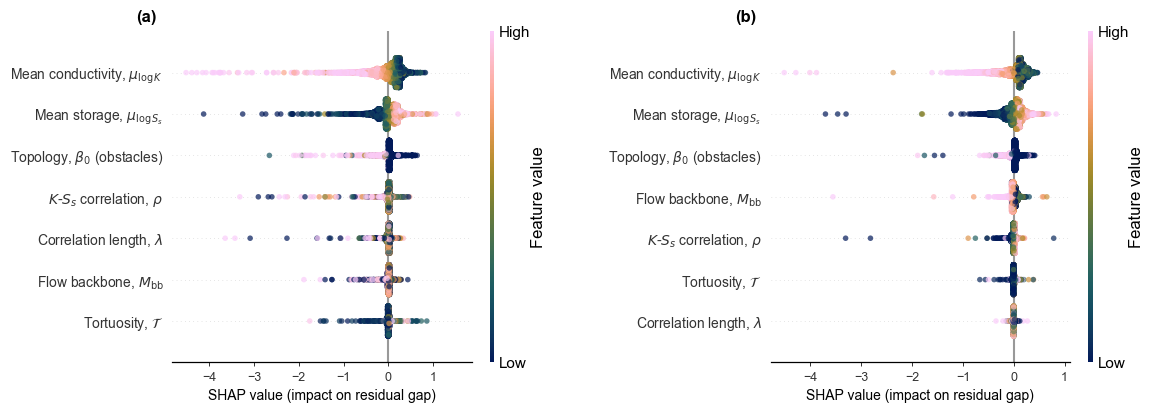

In [112]:
# ==============================================================================
# Figure 4 Step 2. Nature-style SHAP bee-swarm (2 panels)
# ==============================================================================

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ------------------------------------------------------------------
# 1) Configuration
# ------------------------------------------------------------------
DATA_DIR = "Fig4_Data_Cache"

# Academic display names (standard academic notation)
FEATURE_MAP = {
    "Phys_Perc_Tortuosity": r"Tortuosity, $\mathcal{T}$",
    "Phys_Perc_Betti0": r"Topology, $\beta_{0}$ (obstacles)",
    "Phys_Perc_Backbone": r"Flow backbone, $M_{\mathrm{bb}}$",
    "Geostat_Mu_K": r"Mean conductivity, $\mu_{\log K}$",
    "Geostat_Mu_Ss": r"Mean storage, $\mu_{\log S_{s}}$",
    "Geostat_Corr_Ss": r"Correlation length, $\lambda$",
    "Geostat_Rho": r"$K$-$S_s$ correlation, $\rho$",
}

# Matplotlib + vector PDF friendliness
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "font.size": 10,
    "axes.linewidth": 0.9,
    "mathtext.fontset": "dejavusans",
    "pdf.fonttype": 42,   # editable text in Illustrator
    "ps.fonttype": 42,
})

def _batlow():
    try:
        from cmcrameri import cm as cmc
        return cmc.batlow
    except Exception:
        return plt.get_cmap("cividis")

BATLOW = _batlow()

# ------------------------------------------------------------------
# 2) Data loading
# ------------------------------------------------------------------
def load_shap_data(prefix):
    shap_path = os.path.join(DATA_DIR, f"{prefix}_shap_values.npy")
    X_path = os.path.join(DATA_DIR, f"{prefix}_X_data.csv")

    if not os.path.exists(shap_path) or not os.path.exists(X_path):
        raise FileNotFoundError(f"Missing cached files for '{prefix}':\n  {shap_path}\n  {X_path}")

    shap_vals = np.load(shap_path)
    X = pd.read_csv(X_path)
    return shap_vals, X

print("Loading data...")
shap_q, X_q = load_shap_data("Tau_q")
shap_h, X_h = load_shap_data("Tau_h")

# ------------------------------------------------------------------
# 3) Helpers for consistent styling of SHAP summary plots
# ------------------------------------------------------------------
def style_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)
    ax.tick_params(length=3, width=0.7)

def apply_batlow_to_shap_axis(ax, cmap=BATLOW):
    """
    shap.summary_plot creates a scatter collection colored by feature values
    and an accompanying colorbar. We re-map the collection to batlow.
    """
    # Apply to scatter collections
    for coll in ax.collections:
        if hasattr(coll, "get_array") and coll.get_array() is not None:
            try:
                coll.set_cmap(cmap)
            except Exception:
                pass

    # Try to find the colorbar axis (usually the last axis in the figure)
    fig = ax.figure
    if len(fig.axes) >= 2:
        # heuristic: any axis with no x/y ticks and a ylabel like "Feature value"
        for a in fig.axes:
            if a is ax:
                continue
            # Many shap colorbars have no x ticks and have a y-label
            if (len(a.get_xticks()) == 0) and (a.get_ylabel() != ""):
                # this is likely the colorbar axis
                try:
                    # set its colormap by updating its collections if present
                    for coll in a.collections:
                        if hasattr(coll, "set_cmap"):
                            coll.set_cmap(cmap)
                except Exception:
                    pass

def plot_shap_panel(fig, ax, shap_vals, X, title, panel_letter, max_display=7):
    # rename columns to academic display names
    X_disp = X.rename(columns=FEATURE_MAP)

    # SHAP summary plot draws into current axis. set it explicitly.
    plt.sca(ax)
    shap.summary_plot(
        shap_vals, X_disp,
        show=False,
        plot_size=None,
        max_display=max_display,
        alpha=0.70
    )

    # after shap draws, style the axis it created (it should be current)
    ax_now = plt.gca()

    # apply batlow colormap to points and colorbar
    apply_batlow_to_shap_axis(ax_now, cmap=BATLOW)

    # titles and labels
    ax_now.set_title(title, loc="left", fontweight="bold", fontsize=12, pad=10)
    ax_now.set_xlabel(r"SHAP value (impact on residual gap)", fontsize=10)

    # cleaner ticks
    ax_now.tick_params(axis="x", labelsize=9)
    ax_now.tick_params(axis="y", labelsize=10)

    # panel label
    ax_now.text(
        -0.12, 1.02, f"({panel_letter})",
        transform=ax_now.transAxes,
        fontsize=12, fontweight="bold",
        ha="left", va="bottom"
    )

    style_axes(ax_now)

    return ax_now

# ------------------------------------------------------------------
# 4) Plot (2 panels). Use constrained_layout=False + manual adjust for stability
# ------------------------------------------------------------------
fig = plt.figure(figsize=(10.8, 4.6))
gs = fig.add_gridspec(1, 2, wspace=0.60)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Panel (a): tau_q
plot_shap_panel(
    fig, ax1, shap_q, X_q,
    title=r"",
    panel_letter="a",
    max_display=7
)

# Panel (b): tau_h
plot_shap_panel(
    fig, ax2, shap_h, X_h,
    title=r"",
    panel_letter="b",
    max_display=7
)

# Tighten. Extra top margin to avoid title clipping.
fig.subplots_adjust(left=0.08, right=0.98, bottom=0.16, top=0.88, wspace=0.32)

# ------------------------------------------------------------------
# 5) Save
# ------------------------------------------------------------------
out_png = "Figure4.png"
out_pdf = "Figure4.pdf"

fig.savefig(out_png, dpi=600, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
print(f"Saved PNG: {out_png}")
print(f"Saved PDF: {out_pdf}")

plt.show()

✅ Loaded Mission_Hydro_Hybrid_DPL_Rebuilt.csv (10000 samples)
📊 Features used: ['Geostat_Mu_K', 'Geostat_Mu_Ss', 'Geostat_Rho', 'Phys_Perc_Betti0', 'Phys_Perc_Backbone', 'Phys_Perc_Tortuosity', 'Geostat_Corr_Ss']

⚙️ Analyzing mechanisms for Target_LogTau_q...
   -> Saved SHAP to: Fig4_Data_Cache\Tau_q_shap_values.npy

⚙️ Analyzing mechanisms for Target_LogTau_h...
   -> Saved SHAP to: Fig4_Data_Cache\Tau_h_shap_values.npy

✅ Step 1 Analysis Complete (Full Physics Mode)!


# Figure 5

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as pe
import warnings

warnings.filterwarnings('ignore')

# ==============================================================================
# 1. Configuration & Data
# ==============================================================================
CSV_PATH = "Mission_Hydro_Hybrid_DPL_Rebuilt.csv"

# [Key change] Label adjustments
FEATURE_MAP = {
    'Geostat_Mu_K': r'$\mu_{\log K}$',
    'Geostat_Mu_Ss': r'$\mu_{\log S_s}$',
    'Phys_Perc_Backbone': r'$M_{bb}$',
    'Phys_Perc_Betti0': r'$\beta_0$',
    'Phys_Perc_Tortuosity': r'$\mathcal{T}$',
    'Geostat_Corr_Ss': r'$\lambda$',
    'Geostat_Rho': r'$\rho$'
}

try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    import sys; sys.exit("CSV not found")

df = df.dropna(subset=["Target_LogTau_q", "Target_LogTau_h"])

# Compute bias and class
rank_q = df["Target_LogTau_q"].rank(pct=True)
rank_h = df["Target_LogTau_h"].rank(pct=True)
df["Mech_Bias"] = rank_q - rank_h

# Build classes (for LDA)
threshold = 0.15
conditions = [
    (df["Mech_Bias"] < -threshold), # Blue
    (df["Mech_Bias"] > threshold)   # Red
]
choices = [0, 2] 
df["Class"] = np.select(conditions, choices, default=1) # 1=Gray

# Prepare features
features = list(FEATURE_MAP.keys())
X = df[features]
y = df["Class"]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==============================================================================
# 2. Run LDA
# ==============================================================================
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

df["LD1"] = X_lda[:, 0]
df["LD2"] = X_lda[:, 1]

# Extract loadings
loadings = pd.DataFrame(
    lda.scalings_[:, :2], 
    index=features, 
    columns=['LD1', 'LD2']
)


Saved PNG: Figure5.png
Saved PDF: Figure5.pdf


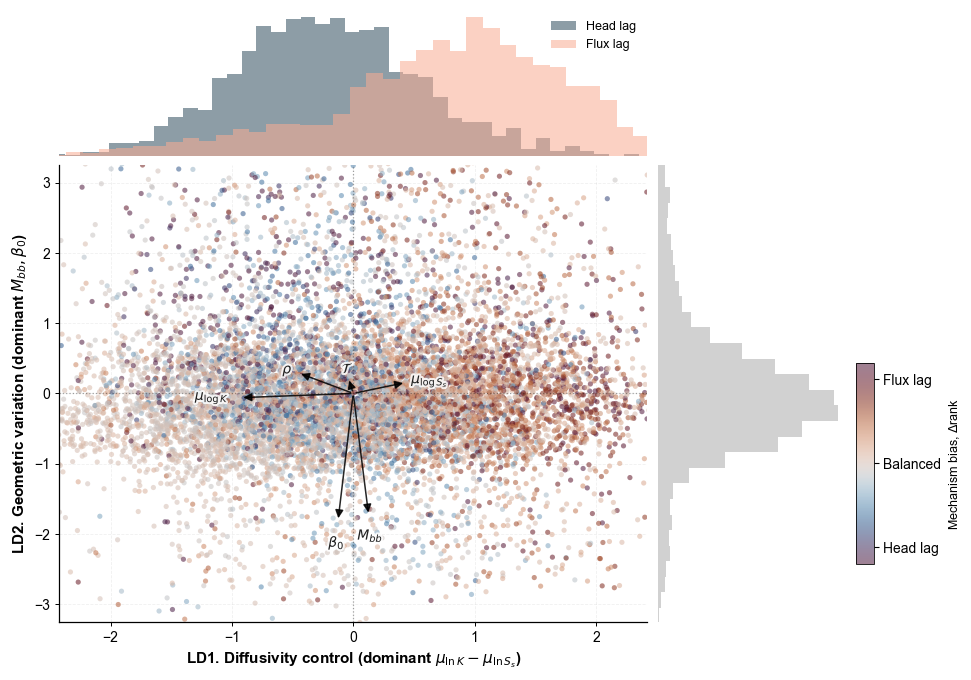

In [105]:

# ==============================================================================
# Figure 5 (Refined). LDA biplot with marginals (Nature-style)
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as pe

# ----------------------------
# Style
# ----------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 10,
    "pdf.fonttype": 42,          # editable text in Illustrator
    "mathtext.fontset": "dejavusans",
    "axes.linewidth": 0.9
})

# Colormaps
try:
    from cmcrameri import cm as cmc
    CMAP_BIAS = cmc.vikO          # diverging for signed bias
    CMAP_CLASS = cmc.batlowK      # sequential for group colors
except Exception:
    CMAP_BIAS = plt.get_cmap("coolwarm")
    CMAP_CLASS = plt.get_cmap("cividis")

def style_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(length=3, width=0.7)

# ----------------------------
# Layout (manual margins to avoid collapse)
# ----------------------------
fig = plt.figure(figsize=(9.6, 7.2))
gs = GridSpec(4, 4, figure=fig, hspace=0.06, wspace=0.06)

ax_main  = fig.add_subplot(gs[1:4, 0:3])
ax_top   = fig.add_subplot(gs[0,   0:3], sharex=ax_main)
ax_right = fig.add_subplot(gs[1:4, 3],   sharey=ax_main)

fig.subplots_adjust(left=0.10, right=0.92, bottom=0.10, top=0.95)

# ----------------------------
# Data & limits
# ----------------------------
LD1 = df["LD1"].to_numpy(dtype=float)
LD2 = df["LD2"].to_numpy(dtype=float)
bias = df["Mech_Bias"].to_numpy(dtype=float)

mask = np.isfinite(LD1) & np.isfinite(LD2) & np.isfinite(bias)
LD1 = LD1[mask]; LD2 = LD2[mask]; bias = bias[mask]

# robust limits (avoid outliers stretching the plot)
LIMIT_X = float(np.nanpercentile(np.abs(LD1), 99))
LIMIT_Y = float(np.nanpercentile(np.abs(LD2), 99))
LIMIT_X = max(LIMIT_X, 1e-6)
LIMIT_Y = max(LIMIT_Y, 1e-6)

# ----------------------------
# Main scatter (all points)
# ----------------------------
sc = ax_main.scatter(
    LD1, LD2,
    c=bias, cmap=CMAP_BIAS,
    s=14, alpha=0.55, edgecolor="none",
    vmin=-0.6, vmax=0.6,
    rasterized=True, zorder=2
)

# zero lines
ax_main.axvline(0, color=(0, 0, 0, 0.35), linestyle=":", linewidth=0.9)
ax_main.axhline(0, color=(0, 0, 0, 0.35), linestyle=":", linewidth=0.9)

ax_main.set_xlim(-LIMIT_X, LIMIT_X)
ax_main.set_ylim(-LIMIT_Y, LIMIT_Y)

ax_main.grid(True, linestyle="--", alpha=0.18, linewidth=0.6)
style_axes(ax_main)

# ----------------------------
# Biplot loadings (vectors + academic labels)
# ----------------------------
max_loading = float(np.nanmax(np.abs(loadings[["LD1", "LD2"]].to_numpy(dtype=float))))
max_loading = max(max_loading, 1e-12)

# scale so longest arrow reaches ~75% of axis limits
scale = 0.75 * min(LIMIT_X, LIMIT_Y) / max_loading

for feat in features:
    wx = float(loadings.loc[feat, "LD1"])
    wy = float(loadings.loc[feat, "LD2"])
    vec_len = float(np.hypot(wx, wy))

    # filter tiny vectors to avoid clutter
    if not np.isfinite(vec_len) or vec_len < 0.20:
        continue

    x2 = wx * scale
    y2 = wy * scale

    ax_main.annotate(
        "", xy=(x2, y2), xytext=(0, 0),
        arrowprops=dict(arrowstyle="-|>", color=(0, 0, 0, 0.85), lw=1.1,
                        mutation_scale=12),
        zorder=5
    )

    # smart label placement (extend beyond tip)
    tx = x2 * 1.10
    ty = y2 * 1.10

    ha = "center"
    va = "center"
    if abs(wx) > abs(wy):
        ha = "left" if wx > 0 else "right"
    else:
        va = "bottom" if wy > 0 else "top"

    label_str = FEATURE_MAP.get(feat, str(feat))
    t = ax_main.text(
        tx, ty, label_str,
        fontsize=10, fontweight="bold",
        color=(0, 0, 0, 0.85),
        ha=ha, va=va, zorder=6
    )
    t.set_path_effects([pe.withStroke(linewidth=3, foreground="white", alpha=0.85)])

# [Key change] Axis label: explicitly indicates diffusivity control
ax_main.set_xlabel(r"LD1. Diffusivity control (dominant $\mu_{\ln K} - \mu_{\ln S_s}$)", fontsize=11, fontweight="bold")
ax_main.set_ylabel(r"LD2. Geometric variation (dominant $M_{bb}, \beta_0$)", fontsize=11, fontweight="bold")

# ----------------------------
# Marginals
# ----------------------------
df_red  = df[df["Class"] == 2]
df_blue = df[df["Class"] == 0]

C_BLUE = CMAP_CLASS(0.20)
C_RED  = CMAP_CLASS(0.80)

ax_top.hist(df_blue["LD1"].to_numpy(float), bins=40, color=C_BLUE, alpha=0.55, density=True, label="Head lag")
ax_top.hist(df_red["LD1"].to_numpy(float),  bins=40, color=C_RED,  alpha=0.55, density=True, label="Flux lag")
ax_top.legend(loc="upper right", fontsize=9, frameon=False)
ax_top.set_axis_off()

ax_right.hist(df["LD2"].to_numpy(float), bins=40, orientation="horizontal",
              color=(0, 0, 0, 0.18), density=True)
ax_right.set_axis_off()

# ----------------------------
# Colorbar
# ----------------------------
cax = fig.add_axes([0.93, 0.18, 0.018, 0.28])
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label(r"Mechanism bias, $\Delta$rank", fontsize=9)
cbar.set_ticks([-0.5, 0.0, 0.5])
cbar.set_ticklabels(["Head lag", "Balanced", "Flux lag"])
cbar.outline.set_linewidth(0.6)

# ----------------------------
# Save
# ----------------------------
out_png = "Figure5.png"
out_pdf = "Figure5.pdf"

fig.savefig(out_png, dpi=600, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
print("Saved PNG:", out_png)
print("Saved PDF:", out_pdf)

plt.show()

# Figure 6

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

# ==============================================================================
# 1. Configuration & Image Generator (Native)
# ==============================================================================
CSV_PATH = "Mission_Hydro_Hybrid_DPL_Rebuilt.csv"

# LaTeX display name mapping
FEATURE_MAP = {
    'Geostat_Mu_K': r'$\mu_{\ln K}$',
    'Geostat_Mu_Ss': r'$\mu_{\ln S_s}$',
    'Phys_Perc_Backbone': r'$M_{bb}$',
    'Phys_Perc_Betti0': r'$\beta_0$',
    'Phys_Perc_Tortuosity': r'$\mathcal{T}$',
    'Geostat_Corr_Ss': r'$\lambda$',
    'Geostat_Rho': r'$\rho$'
}

def gen_lnK_native(nx, ny, dx, seed, model_type, sigma_ln=4.0, corr_len=2.0):
    """Rebuild rock structure (replicates the generation logic)"""
    rng = np.random.default_rng(int(seed))
    z = rng.normal(0, 1, (ny, nx))
    f = gaussian_filter(z, sigma=max(1e-6, corr_len/dx), mode="reflect")
    f = (f - f.mean())/(f.std()+1e-12)

    if model_type == 1: # Connectivity (Channels)
        g = -np.abs(f)
        g = (g - g.mean())/(g.std()+1e-12)
    elif model_type == 2: # Boolean (Obstacles)
        g = np.where(f > 0.0, 1.0, -1.0)
    else: # Gaussian
        g = f
    return g

def get_binary_rock(field, porosity_target=0.6):
    threshold = np.percentile(field, (1-porosity_target)*100)
    return field > threshold

# ==============================================================================
# 2. Data Loading & LDA Processing (Align with Figure 5)
# ==============================================================================
try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    import sys; sys.exit("CSV not found")

# Base filtering
df = df.dropna(subset=["Target_LogTau_q", "Target_LogTau_h"])

# Compute bias and class
rank_q = df["Target_LogTau_q"].rank(pct=True)
rank_h = df["Target_LogTau_h"].rank(pct=True)
df["Mech_Bias"] = rank_q - rank_h

threshold = 0.15
conditions = [(df["Mech_Bias"] < -threshold), (df["Mech_Bias"] > threshold)]
choices = [0, 2] # 0=Blue, 2=Red
df["Class"] = np.select(conditions, choices, default=1)

# LDA projection (using all 7 features)
features = list(FEATURE_MAP.keys())
X = df[features]
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

df["LD1"] = X_lda[:, 0]
df["LD2"] = X_lda[:, 1]

# ==============================================================================
# 3. Selection: Find Extremes in LDA Space
# ==============================================================================
# Strategy: find the farthest points along LD1 (mechanism axis)
# More negative LD1 -> head lag (blue)
# More positive LD1 -> flux lag (red)

# Find the bluest point (minimum LD1)
case_blue = df.nsmallest(1, "LD1").iloc[0]

# Find the reddest point (maximum LD1)
case_red = df.nlargest(1, "LD1").iloc[0]

print(f"🔵 Blue Case (Min LD1): Idx={case_blue['idx']:.0f}, LD1={case_blue['LD1']:.2f}")
print(f"🔴 Red Case (Max LD1): Idx={case_red['idx']:.0f}, LD1={case_red['LD1']:.2f}")

# ==============================================================================
# 4. Image Reconstruction
# ==============================================================================
NX, NY = 200, 200
dx = 100.0 / (NX-1)

# Reconstruct red (Model 2: Boolean)
field_red = gen_lnK_native(NX, NY, dx, seed=case_red['idx'], model_type=2) 
img_red = get_binary_rock(field_red, porosity_target=0.5)

# Reconstruct blue (Model 1: Connectivity)
field_blue = gen_lnK_native(NX, NY, dx, seed=case_blue['idx'], model_type=1)
img_blue = get_binary_rock(field_blue, porosity_target=0.7)



🔵 Blue Case (Min LD1): Idx=8929, LD1=-3.27
🔴 Red Case (Max LD1): Idx=9761, LD1=3.01


Saved PDF: Figure6.pdf
Saved PNG: Figure6.png


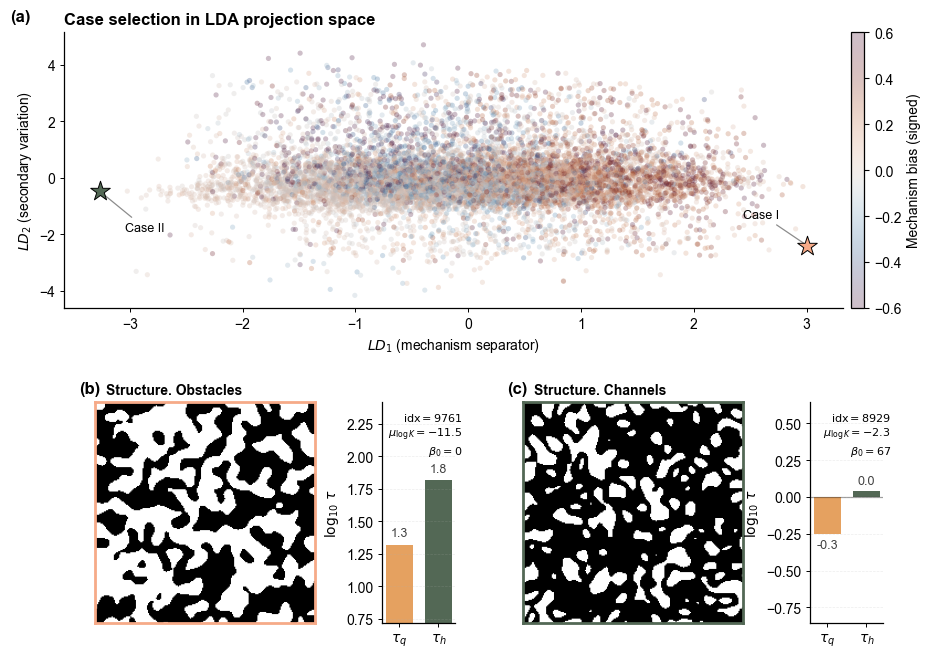

In [108]:
# ==============================================================================
# Figure 6 (Refined). LDA context + two extreme cases (Nature-style)
# - Uses cmc.batlow (sequential) for continuous colour (Mech_Bias) instead of red/blue semantics
# - Keeps a diverging map ONLY if Mech_Bias is truly signed and you want sign emphasis (optional switch)
# - Academic notation for axes/labels (LD1, LD2, τ_q, τ_h, μ_{ln K}, β_0)
# - Cleaner layout: top wide LDA map, bottom row has two case blocks (each block = image + bar)
#   with width ratio per block ~ 2:1 (image:bar)
# - Adds PDF save (requested) + optional PNG
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import os

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 10,
    "axes.linewidth": 0.9,
    "mathtext.fontset": "dejavusans",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ---- colormap helpers ----
def _batlow():
    try:
        from cmcrameri import cm as cmc
        return cmc.batlowK
    except Exception:
        return plt.get_cmap("cividis")

def _vik():
    try:
        from cmcrameri import cm as cmc
        return cmc.vikO
    except Exception:
        return plt.get_cmap("coolwarm")

# Choose one:
# 1) sequential (batlow) for magnitude-style reading (recommended for "conservative" tone)
# 2) diverging (vik) if sign is core to your story
USE_DIVERGING = True

if USE_DIVERGING:
    cmap_bias = _vik()
    vlim = 0.6
    norm_bias = Normalize(vmin=-vlim, vmax=vlim)
else:
    cmap_bias = _batlow()
    # robust sequential scaling
    v0 = float(np.nanpercentile(df["Mech_Bias"], 2))
    v1 = float(np.nanpercentile(df["Mech_Bias"], 98))
    norm_bias = Normalize(vmin=v0, vmax=v1)

# batlow accents for case styling (no red/blue primaries)
bat = _batlow()
C_CASE1 = bat(0.78)
C_CASE2 = bat(0.35)

def style_axes(ax, grid_axis=None):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis is not None:
        ax.grid(True, axis=grid_axis, linestyle="--", linewidth=0.5, alpha=0.22)
    ax.tick_params(length=3, width=0.7)

def panel_label(ax, letter, xy=(-0.07, 1.03)):
    ax.text(xy[0], xy[1], f"({letter})", transform=ax.transAxes,
            ha="left", va="bottom", fontsize=12, fontweight="bold", clip_on=False)

# ==============================================================================
# Layout
# ==============================================================================
fig = plt.figure(figsize=(9, 7.2))
gs = GridSpec(
    2, 6, figure=fig,
    height_ratios=[1.25, 1.0],
    # bottom row: [img1 img1 bar1 | img2 img2 bar2]
    width_ratios=[2.0, 2.0, 1.2, 2.0, 2.0, 1.2],
    hspace=0.38, wspace=0.35
)
fig.subplots_adjust(left=0.07, right=0.98, top=0.92, bottom=0.10)

# ==============================================================================
# (a) LDA phase space
# ==============================================================================
ax_map = fig.add_subplot(gs[0, :])
panel_label(ax_map, "a")

# background points
sc = ax_map.scatter(
    df["LD1"], df["LD2"],
    c=df["Mech_Bias"], cmap=cmap_bias, norm=norm_bias,
    s=14, alpha=0.28, rasterized=True, linewidths=0
)

# selected cases (use same star marker, different batlow tones)
ax_map.scatter(case_red["LD1"], case_red["LD2"], s=220, c=[C_CASE1], marker="*", edgecolors="k",
               linewidths=0.7, zorder=6, label="Case I")
ax_map.scatter(case_blue["LD1"], case_blue["LD2"], s=220, c=[C_CASE2], marker="*", edgecolors="k",
               linewidths=0.7, zorder=6, label="Case II")

ax_map.set_xlabel(r"$LD_1$ (mechanism separator)")
ax_map.set_ylabel(r"$LD_2$ (secondary variation)")
ax_map.set_title("Case selection in LDA projection space", loc="left", fontweight="bold")

# compact annotations
ax_map.annotate(
    "Case I",
    xy=(float(case_red["LD1"]), float(case_red["LD2"])),
    xytext=(-20, 18), textcoords="offset points",
    arrowprops=dict(arrowstyle="-", color=(0, 0, 0, 0.45), lw=0.9),
    fontsize=9, ha="right", va="bottom"
)
ax_map.annotate(
    "Case II",
    xy=(float(case_blue["LD1"]), float(case_blue["LD2"])),
    xytext=(18, -22), textcoords="offset points",
    arrowprops=dict(arrowstyle="-", color=(0, 0, 0, 0.45), lw=0.9),
    fontsize=9, ha="left", va="top"
)

style_axes(ax_map, grid_axis=None)

# colorbar
cbar = fig.colorbar(sc, ax=ax_map, pad=0.01, fraction=0.04)
cbar.set_label("Mechanism bias (a.u.)" if not USE_DIVERGING else "Mechanism bias (signed)")

#ax_map.legend(frameon=False, loc="upper right", ncol=2)

# ==============================================================================
# Helper: case block (image + lag bars)
# ==============================================================================
def plot_case_block(ax_img, ax_bar, img, case_data, title_text, letter_img, letter_bar, edge_color):
    # image
    ax_img.imshow(img, cmap="gray_r", origin="lower")
    ax_img.set_xticks([]); ax_img.set_yticks([])
    for sp in ax_img.spines.values():
        sp.set_visible(True)
        sp.set_edgecolor(edge_color)
        sp.set_linewidth(2.0)
    panel_label(ax_img, letter_img)
    ax_img.set_title(title_text, loc="left", x=0.05, fontweight="bold", fontsize=10)

    # lag bars

    lags = [float(case_data["Target_LogTau_q"]), float(case_data["Target_LogTau_h"])]
    names = [r"$\log_{10}\,\tau_q$", r"$\log_{10}\,\tau_h$"]
    col_tauq = bat(0.70)
    col_tauh = bat(0.35)

    ax_bar.bar([0, 1], lags, color=[col_tauq, col_tauh], edgecolor=(0, 0, 0, 0.15), linewidth=0.0, width=0.70)
    ax_bar.axhline(0, color=(0, 0, 0, 0.35), lw=0.9)
    ax_bar.set_xticks([0, 1])
    ax_bar.set_xticklabels([r"$\tau_q$", r"$\tau_h$"])
    ax_bar.set_ylabel(r"$\log_{10}\,\tau$")

    y0, y1 = min(lags), max(lags)
    pad = max(0.6, 0.25 * (y1 - y0 + 1e-12))
    ax_bar.set_ylim(y0 - pad, y1 + pad)

    for i, v in enumerate(lags):
        ax_bar.text(i, v + (0.08 if v >= 0 else -0.10) * (y1 - y0 + 1e-12),
                    f"{v:.1f}", ha="center",
                    va="bottom" if v >= 0 else "top", fontsize=9, color=(0, 0, 0, 0.75))

    # stats box (academic notation)
    stats_txt = (
        rf"$\mathrm{{idx}}={float(case_data['idx']):.0f}$" "\n"
        rf"$\mu_{{\log K}}={float(case_data['Geostat_Mu_K']):.1f}$" "\n"
        rf"$\beta_0={float(case_data['Phys_Perc_Betti0']):.0f}$"
    )
    ax_bar.text(
        1.1, 0.96, stats_txt,
        transform=ax_bar.transAxes, ha="right", va="top",
        fontsize=8
    )

    style_axes(ax_bar, grid_axis="y")

# ==============================================================================
# Bottom row: Case I block (b,c) and Case II block (d,e)
# ==============================================================================
ax_img1 = fig.add_subplot(gs[1, 0:2])
ax_bar1 = fig.add_subplot(gs[1, 2])
plot_case_block(
    ax_img1, ax_bar1,
    img_red, case_red,
    "Structure. Obstacles",
    "b", "", edge_color=C_CASE1
)

ax_img2 = fig.add_subplot(gs[1, 3:5])
ax_bar2 = fig.add_subplot(gs[1, 5])
plot_case_block(
    ax_img2, ax_bar2,
    img_blue, case_blue,
    "Structure. Channels",
    "c", "", edge_color=C_CASE2
)

# ==============================================================================
# Save
# ==============================================================================
out_pdf = "Figure6.pdf"
out_png = "Figure6.png"

fig.savefig(out_pdf, bbox_inches="tight")
print("Saved PDF:", out_pdf)

fig.savefig(out_png, dpi=600, bbox_inches="tight")
print("Saved PNG:", out_png)

plt.show()


# Figure 7

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from matplotlib.gridspec import GridSpec
import warnings
import textwrap

warnings.filterwarnings('ignore')

# ==============================================================================
# 1. Configuration & Data (Consistent with Fig 3)
# ==============================================================================
CSV_PATH = "Mission_Hydro_Hybrid_DPL_Rebuilt.csv"
CONFIG = {"N_CUTOFF": 9200}
NAME_MAP = {
    'Phys_Perc_Backbone': 'M', 'Phys_Perc_Betti0': 'B',
    'Phys_Perc_Tortuosity': 'T', 'Geostat_Corr_Ss': 'L', 'Geostat_Rho': 'R'
}

try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    import sys; sys.exit("CSV not found")

df = df.dropna(subset=["Target_LogTau_q", "Target_LogTau_h"])
df["Phys_Theory"] = np.log10(df["Geostat_Mu_Ss"] / (df["Geostat_Mu_K"] + 1e-12))

# ==============================================================================
# 2. Enhanced SINDy Engine
# ==============================================================================
def discover_enhanced_equation_final(df, target_col, target_name):
    # Step 1: Base Physics
    X_theory = df["Phys_Theory"].values.reshape(-1, 1)
    y_true = df[target_col].values
    
    reg_base = LinearRegression().fit(X_theory, y_true)
    y_base_all = reg_base.predict(X_theory)
    base_coef = reg_base.coef_[0]
    
    # Residuals
    residuals_all = y_true - y_base_all
    
    # Step 2: Golden Filtering
    df_temp = df.copy()
    df_temp['Resid_Sq'] = residuals_all**2
    df_temp['Residuals'] = residuals_all
    df_temp['Base_Pred'] = y_base_all
    df_golden = df_temp.sort_values('Resid_Sq').head(CONFIG["N_CUTOFF"]).copy()
    
    # Step 3: Advanced Features
    geo_cols = list(NAME_MAP.keys())
    X_raw = df_golden[geo_cols].copy()
    
    epsilon = 1e-3
    for c in geo_cols:
         X_raw[f"ln_{NAME_MAP[c]}"] = np.log1p(df_golden[c])
         X_raw[f"inv_{NAME_MAP[c]}"] = 1.0 / (df_golden[c] + epsilon)
            
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_poly = poly.fit_transform(X_raw)
    feat_names = poly.get_feature_names_out(X_raw.columns)
    
    clean_names = []
    for name in feat_names:
        for long_n, short_n in NAME_MAP.items():
            name = name.replace(long_n, short_n)
        name = name.replace(" ", r"\cdot ")
        clean_names.append(name)
        
    X_df = pd.DataFrame(X_poly, columns=clean_names, index=df_golden.index)
    
    # Normalize
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_df), columns=clean_names, index=df_golden.index)
    
    # Step 4: Lasso Selection + OLS Refit
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=100000)
    lasso.fit(X_scaled, df_golden['Residuals'])
    
    # Select Features (Non-zero)
    mask = np.abs(lasso.coef_) > 1e-4
    selected_feats = X_scaled.columns[mask]
    
    # Fallback if too few
    if len(selected_feats) == 0:
        top_idx = np.argsort(np.abs(lasso.coef_))[::-1][:1]
        selected_feats = X_scaled.columns[top_idx]
    
    # Refit OLS
    ols = LinearRegression()
    ols.fit(X_scaled[selected_feats], df_golden['Residuals'])
    
    y_resid_pred = ols.predict(X_scaled[selected_feats])
    y_final_pred = df_golden['Base_Pred'] + y_resid_pred
    total_r2 = r2_score(df_golden[target_col], y_final_pred)
    
    # Extract Coefs
    final_coefs = pd.Series(0.0, index=clean_names)
    final_coefs[selected_feats] = ols.coef_
    
    # Make Equation String (Top 3)
    eq = f"${target_name} \\approx {base_coef:.2f} \\log(\\frac{{S_s}}{{K}})"
    top_terms = final_coefs.abs().sort_values(ascending=False).head(3)
    for term, val in final_coefs[top_terms.index].items():
        sign = "+" if val > 0 else "-"
        term_tex = term.replace('B', r'\beta_0').replace('M', r'M_{bb}')\
                       .replace('ln_', r'\ln ').replace('inv_', r'\frac{1}{')\
                       .replace('T', r'\mathcal{T}').replace('·', r'\cdot ')
        if r'\frac{1}{' in term_tex and '}' not in term_tex[-1]: 
             if r'\cdot' not in term_tex: term_tex += "}"
        eq += f" {sign} {abs(val):.2f} {term_tex}"
    eq += "$"
    
    return eq, df_golden[target_col], y_final_pred, total_r2, final_coefs

print("🤖 Running Final Figure 7 Generation...")
eq_q, y_true_q, pred_q, r2_q, coefs_q = discover_enhanced_equation_final(df, "Target_LogTau_q", r"\tau_q")
eq_h, y_true_h, pred_h, r2_h, coefs_h = discover_enhanced_equation_final(df, "Target_LogTau_h", r"\tau_h")

print(f"   Tau_q R2: {r2_q:.3f} | Terms: {len(coefs_q[coefs_q!=0])}")
print(f"   Tau_h R2: {r2_h:.3f} | Terms: {len(coefs_h[coefs_h!=0])}")

# ==============================================================================
# 3. Plotting Figure 7 (Top 6 + Others)
# ==============================================================================
plt.rcParams.update({
    "font.family": "sans-serif", "font.size": 10, "pdf.fonttype": 42,
    "mathtext.fontset": "dejavusans"
})


🤖 Running Final Figure 7 Generation...
   Tau_q R2: 0.454 | Terms: 23
   Tau_h R2: 0.485 | Terms: 1


Saved PNG: Figure7.png
Saved PDF: Figure7.pdf


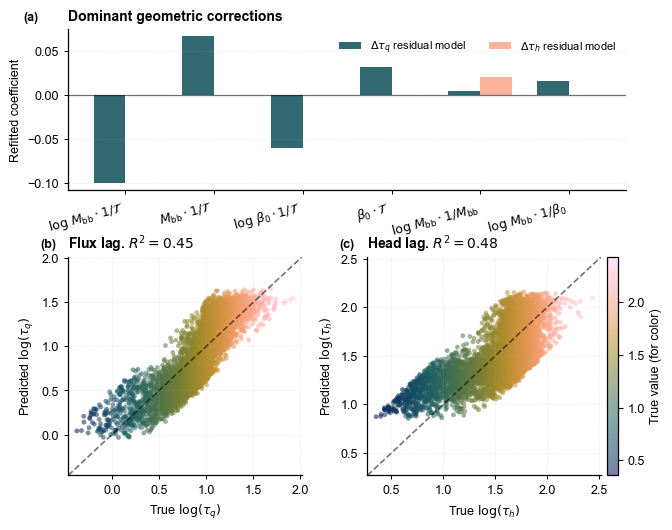

In [131]:
# ==============================================================================
# Figure 7 (Refined, Nature-style)
# Panels:
# (a) Top geometric correction coefficients (Δτ_q vs Δτ_h), batlow colors + academic labels
# (b) True vs Predicted log10(τ_q) with batlow colormap + compact equation inset
# (c) True vs Predicted log10(τ_h) with batlow colormap + compact equation inset
#
# Changes vs your original:
# - Uses cmc.batlow consistently (no Reds/Blues, no hard-coded red/blue bars)
# - Academic math labels with proper subscripts, ln, inverse, and dot products
# - Cleaner tick labels and legend. Shared visual language across panels
# - Saves to PDF (requested) + optional PNG
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import textwrap

# ----------------------------
# Colormap helpers
# ----------------------------
def _batlow():
    try:
        from cmcrameri import cm as cmc
        return cmc.batlow
    except Exception:
        return plt.get_cmap("cividis")

def _batlow_discrete(n):
    cmap = _batlow()
    return [cmap(v) for v in np.linspace(0.22, 0.80, n)]

BATLOW = _batlow()

# ----------------------------
# Academic term formatter
# ----------------------------
def format_term_academic(t: str) -> str:
    """
    Convert term strings into standard academic notation.
    This is rule-based and conservative. It will not invent meaning.
    Examples:
      'B' -> β_0
      'M' -> M_bb
      'T' -> 𝒯
      'ln_K' -> ln K
      'inv_X' -> 1/X
      '·' or '*' -> · (dot)
    """
    s = str(t)

    # Normalize separators
    s = s.replace("*", "·")

    # Common replacements (your original intent)
    s = s.replace("B", r"\beta_{0}")
    s = s.replace("M", r"M_{\mathrm{bb}}")
    s = s.replace("T", r"\mathcal{T}")

    # ln_foo -> ln foo
    s = s.replace("ln_", r"\log\,")
    # inv_foo -> 1/foo
    s = s.replace("inv_", r"1/")

    # dot
    s = s.replace("·", r"\cdot ")

    # Wrap as mathtext
    return rf"${s}$"

# ----------------------------
# Styling helpers
# ----------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "legend.fontsize": 8,
    "mathtext.fontset": "dejavusans",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

def style_axes(ax, grid_axis="y"):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis is not None:
        ax.grid(True, axis=grid_axis, linestyle="--", linewidth=0.5, alpha=0.22)
    ax.tick_params(length=3, width=0.7)

# ----------------------------
# Figure layout
# ----------------------------
fig = plt.figure(figsize=(7.2, 5.8))
gs = GridSpec(2, 2, height_ratios=[0.85, 1.15], hspace=0.35, wspace=0.28)

# ==============================================================================
# (a) Coefficient strength (Top 6)
# ==============================================================================
ax_coef = fig.add_subplot(gs[0, :])
ax_coef.text(-0.08, 1.03, "(a)", transform=ax_coef.transAxes, fontweight="bold", va="bottom")

combined_magnitude = coefs_q.abs() + coefs_h.abs()
top_terms = combined_magnitude.sort_values(ascending=False).head(6).index.tolist()

vals_q = np.array([coefs_q.get(k, 0.0) for k in top_terms], dtype=float)
vals_h = np.array([coefs_h.get(k, 0.0) for k in top_terms], dtype=float)

x = np.arange(len(top_terms), dtype=float)
w = 0.36

# batlow colors
C_Q, C_H = _batlow_discrete(2)

ax_coef.bar(x - w/2, vals_q, w, color=C_Q, alpha=0.90, edgecolor=(0, 0, 0, 0.20), linewidth=0.0,
            label=r"$\Delta \tau_q$ residual model")
ax_coef.bar(x + w/2, vals_h, w, color=C_H, alpha=0.85, edgecolor=(0, 0, 0, 0.20), linewidth=0.0,
            label=r"$\Delta \tau_h$ residual model")

ax_coef.axhline(0, color=(0, 0, 0, 0.55), lw=0.9)

labels = [format_term_academic(t) for t in top_terms]
ax_coef.set_xticks(x)
ax_coef.set_xticklabels(labels, rotation=15, ha="right")

ax_coef.set_ylabel("Refitted coefficient")
ax_coef.set_title("Dominant geometric corrections", loc="left", fontweight="bold")
style_axes(ax_coef, grid_axis="y")
ax_coef.legend(frameon=False, ncol=2, loc="upper right")

# ==============================================================================
# (b) Flux lag: true vs predicted
# ==============================================================================
ax_b = fig.add_subplot(gs[1, 0])
ax_b.text(-0.12, 1.03, "(b)", transform=ax_b.transAxes, fontweight="bold", va="bottom")

# color by true value using batlow
m_b = np.isfinite(y_true_q) & np.isfinite(pred_q)
xq = np.asarray(y_true_q)[m_b]
yq = np.asarray(pred_q)[m_b]

sc_b = ax_b.scatter(
    xq, yq,
    c=xq, cmap=BATLOW,
    s=12, alpha=0.55, linewidths=0,
    rasterized=True
)

lo = float(np.nanmin(np.r_[xq, yq]))
hi = float(np.nanmax(np.r_[xq, yq]))
pad = 0.04 * (hi - lo + 1e-12)
lo, hi = lo - pad, hi + pad
ax_b.plot([lo, hi], [lo, hi], ls="--", lw=1.2, color=(0, 0, 0, 0.55))
ax_b.set_xlim(lo, hi)
ax_b.set_ylim(lo, hi)

ax_b.set_xlabel(r"True $\log(\tau_q)$")
ax_b.set_ylabel(r"Predicted $\log(\tau_q)$")
ax_b.set_title(rf"Flux lag. $R^2={r2_q:.2f}$", loc="left", fontweight="bold")
style_axes(ax_b, grid_axis="both")


# ==============================================================================
# (c) Head lag: true vs predicted
# ==============================================================================
ax_c = fig.add_subplot(gs[1, 1])
ax_c.text(-0.12, 1.03, "(c)", transform=ax_c.transAxes, fontweight="bold", va="bottom")

m_c = np.isfinite(y_true_h) & np.isfinite(pred_h)
xh = np.asarray(y_true_h)[m_c]
yh = np.asarray(pred_h)[m_c]

sc_c = ax_c.scatter(
    xh, yh,
    c=xh, cmap=BATLOW,
    s=12, alpha=0.55, linewidths=0,
    rasterized=True
)

lo = float(np.nanmin(np.r_[xh, yh]))
hi = float(np.nanmax(np.r_[xh, yh]))
pad = 0.04 * (hi - lo + 1e-12)
lo, hi = lo - pad, hi + pad
ax_c.plot([lo, hi], [lo, hi], ls="--", lw=1.2, color=(0, 0, 0, 0.55))
ax_c.set_xlim(lo, hi)
ax_c.set_ylim(lo, hi)

ax_c.set_xlabel(r"True $\log(\tau_h)$")
ax_c.set_ylabel(r"Predicted $\log(\tau_h)$")
ax_c.set_title(rf"Head lag. $R^2={r2_h:.2f}$", loc="left", fontweight="bold")
style_axes(ax_c, grid_axis="both")


# one shared colorbar for panels (b,c). keep compact
cbar = fig.colorbar(sc_c, ax=[ax_b, ax_c], pad=0.01, fraction=0.035)
cbar.set_label(r"True value (for color)")

# ==============================================================================
# Save
# ==============================================================================
out_png = "Figure7.png"
out_pdf = "Figure7.pdf"

fig.savefig(out_png, dpi=600, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
print("Saved PNG:", out_png)
print("Saved PDF:", out_pdf)

plt.show()


In [128]:
from IPython.display import display, Math

print("="*60)
print("📝 Discovered Physical Laws (Raw LaTeX for Manuscript)")
print("="*60)

# 1. Print the raw LaTeX string (easy to copy into Overleaf/LaTeX)
print(f"Flux Lag (Tau_q) Equation:\n{eq_q}")
print("-" * 60)
print(f"Head Lag (Tau_h) Equation:\n{eq_h}")

print("\n" + "="*60)
print("👁️ Rendered Equations (Notebook View)")
print("="*60)

# 2. Render equations in the notebook (visual check)
# Remove surrounding '$' to render correctly in display
display(Math(eq_q.strip('$')))
display(Math(eq_h.strip('$')))

📝 Discovered Physical Laws (Raw LaTeX for Manuscript)
Flux Lag (Tau_q) Equation:
$\tau_q \approx -1.43 \log(\frac{S_s}{K}) - 0.10 \ln M_{bb}\cdot \frac{1}{\mathcal{T} + 0.07 M_{bb}\cdot \frac{1}{\mathcal{T} - 0.06 \ln \beta_0\cdot \frac{1}{\mathcal{T}$
------------------------------------------------------------
Head Lag (Tau_h) Equation:
$\tau_h \approx -1.13 \log(\frac{S_s}{K}) + 0.02 \ln M_{bb}\cdot \frac{1}{M_{bb} - 0.00 M_{bb} - 0.00 \mathcal{T}$

👁️ Rendered Equations (Notebook View)


<IPython.core.display.Math object>

<IPython.core.display.Math object>